# Technical Analysis and Backtesting Framework for Stock Trading

In [1]:
!pip install --quiet yfinance mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import os

def fetch_data (ticker, start = "2015-01-01", end = "2024-12-31", cache = True):
    filename = f"{ticker}.csv"
    if cache and os.path.exists (filename):
        df = pd.read_csv (filename, index_col = "Date", parse_dates = True)
        return df
    df = yf.download (ticker, start = start, end = end, progress = False, auto_adjust = False)
    if isinstance (df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values (0)
    df.index.name = "Date"
    df.to_csv (filename)
    return df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [2]:
tickers = ["TCS.NS", "INFY.NS", "RELIANCE.NS", "HDFCBANK.NS", "ITC.NS"]
stock_data = {}
for t in tickers:
    print (f"Fetching data for {t}...")
    stock_data [t] = fetch_data (t)
print ("\n Available Stocks:")
for i, t in enumerate (tickers, 1):
    print (f"{i}. {t}")
selected_index = int (input ("Choose a stock by number (1 - 5): "))
ticker = tickers [selected_index - 1]
df = stock_data [ticker]

Fetching data for TCS.NS...
Fetching data for INFY.NS...
Fetching data for RELIANCE.NS...
Fetching data for HDFCBANK.NS...
Fetching data for ITC.NS...

 Available Stocks:
1. TCS.NS
2. INFY.NS
3. RELIANCE.NS
4. HDFCBANK.NS
5. ITC.NS
Choose a stock by number (1 - 5): 2


In [3]:
class SMAIndicator:
    def __init__ (self, window): self.window = window
    def calculate (self, df): return df ['Close'].rolling (window = self.window).mean ()

class EMAIndicator:
    def __init__ (self, window): self.window = window
    def calculate (self, df): return df ['Close'].ewm (span = self.window, adjust = False).mean ()

class RSIIndicator:
    def __init__ (self, window = 14): self.window = window
    def calculate (self, df):
        delta = df ['Close'].diff ()
        gain = (delta.where (delta > 0, 0)).rolling (window = self.window).mean ()
        loss = (-delta.where (delta < 0, 0)).rolling (window = self.window).mean ()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

class MACDIndicator:
    def __init__ (self, fast = 12, slow = 26, signal = 9):
        self.fast, self.slow, self.signal = fast, slow, signal
    def calculate (self, df):
        ema_fast = df ['Close'].ewm (span = self.fast, adjust = False).mean ()
        ema_slow = df ['Close'].ewm (span = self.slow, adjust = False).mean ()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm (span = self.signal, adjust = False).mean ()
        return macd, signal_line

class VWAPIndicator:
    def calculate (self, df: pd.DataFrame) -> pd.Series:
        vwap = (df ['Close'] * df['Volume']).cumsum () / df['Volume'].cumsum ()
        return vwap

In [4]:
from abc import ABC, abstractmethod
class BaseStrategy (ABC):
    @abstractmethod
    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        pass

class MovingAverageCrossoverStrategy (BaseStrategy):
    def __init__ (self, short_window = 50, long_window = 200):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy ()
        df ['SMA_50'] = df ['Close'].rolling (window = self.short_window).mean ()
        df ['SMA_200'] = df ['Close'].rolling (window = self.long_window).mean ()
        df ['Signal'] = 0
        df.loc [df ['SMA_50'] > df ['SMA_200'], 'Signal'] = 1
        df.loc [df ['SMA_50'] < df ['SMA_200'], 'Signal'] = -1
        df ['Position'] = df ['Signal'].shift ().fillna (0)
        return df

class RSIMACDStrategy (BaseStrategy):
    def __init__ (self, rsi_window = 14, macd_fast = 12, macd_slow = 26, macd_signal = 9):
        self.rsi_window = rsi_window
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal

    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy ()
        delta = df ['Close'].diff ()
        gain = delta.clip (lower = 0)
        loss = -delta.clip (upper = 0)
        avg_gain = gain.rolling (window = self.rsi_window).mean ()
        avg_loss = loss.rolling (window = self.rsi_window).mean ()
        rs = avg_gain / avg_loss
        df ['RSI'] = 100 - (100 / (1 + rs))
        ema_fast = df ['Close'].ewm (span = self.macd_fast, adjust = False).mean ()
        ema_slow = df ['Close'].ewm (span = self.macd_slow, adjust = False).mean ()
        df ['MACD'] = ema_fast - ema_slow
        df ['MACD_Signal'] = df ['MACD'].ewm (span = self.macd_signal, adjust = False).mean ()
        df['Signal'] = 0
        buy = (df ['RSI'] < 30) & (df ['MACD'] > df ['MACD_Signal']) & (df ['MACD'].shift (1) <= df ['MACD_Signal'].shift (1))
        sell = (df ['RSI'] > 70) & (df ['MACD'] < df ['MACD_Signal']) & (df ['MACD'].shift (1) >= df ['MACD_Signal'].shift (1))
        df.loc [buy, 'Signal'] = 1
        df.loc [sell, 'Signal'] = -1
        df ['Position'] = df ['Signal'].shift ().fillna (0)
        return df

class CombinedStrategy (BaseStrategy):
    def __init__ (self, short_window = 50, long_window = 200, rsi_window = 14, macd_fast = 12, macd_slow = 26, macd_signal = 9):
        self.sma_strategy = MovingAverageCrossoverStrategy (short_window, long_window)
        self.rsi_macd_strategy = RSIMACDStrategy (rsi_window, macd_fast, macd_slow, macd_signal)

    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        df_sma = self.sma_strategy.generate_signals (df)
        df_rsi_macd = self.rsi_macd_strategy.generate_signals (df)
        df_combined = df.copy ()
        df_combined ['SMA_50'] = df_sma ['SMA_50']
        df_combined ['SMA_200'] = df_sma ['SMA_200']
        df_combined ['RSI'] = df_rsi_macd ['RSI']
        df_combined ['MACD'] = df_rsi_macd ['MACD']
        df_combined ['MACD_Signal'] = df_rsi_macd ['MACD_Signal']
        df_combined ['Signal_SMA'] = df_sma ['Signal']
        df_combined ['Signal_RSI_MACD'] = df_rsi_macd ['Signal']
        df_combined ['Signal'] = 0
        df_combined.loc [(df_combined ['Signal_SMA'] == 1) & (df_combined ['Signal_RSI_MACD'] == 1),'Signal'] = 1
        df_combined.loc [(df_combined['Signal_SMA'] == -1) & (df_combined['Signal_RSI_MACD'] == -1), 'Signal'] = -1
        df_combined ['Position'] = df_combined ['Signal'].shift ().fillna (0)
        df_combined ['Buy'] = df_combined.apply (lambda row: row ['Close'] if row ['Signal'] == 1 else np.nan, axis = 1)
        df_combined ['Sell'] = df_combined.apply (lambda row: row ['Close'] if row ['Signal'] == -1 else np.nan, axis = 1)
        return df_combined

In [5]:
strategy_choice = input ("Choose strategy: 'SMA', 'RSI + MACD', or 'Combined': ")
if strategy_choice == 'SMA':
    strategy = MovingAverageCrossoverStrategy()
    strategy_name = "SMA 50 / 200 crossover"
elif strategy_choice == 'RSI + MACD':
    strategy = RSIMACDStrategy()
    strategy_name = "RSI + MACD strategy"
elif strategy_choice == 'Combined':
    strategy = CombinedStrategy ()
    strategy_name = "SMA + RSI + MACD combined strategy"
else:
    raise ValueError ("Invalid strategy selected")

Choose strategy: 'SMA', 'RSI + MACD', or 'Combined': Combined


📈 Strategy Report
-------------------
Stock: INFY.NS
Strategy: Your_Strategy
Total Trades: 0
Win Rate: 0.0 %
Final Portfolio Value: ₹ 236,410.00
CAGR: 9.19 %
Sharpe Ratio: 0.62
Max Drawdown: -29.87 %


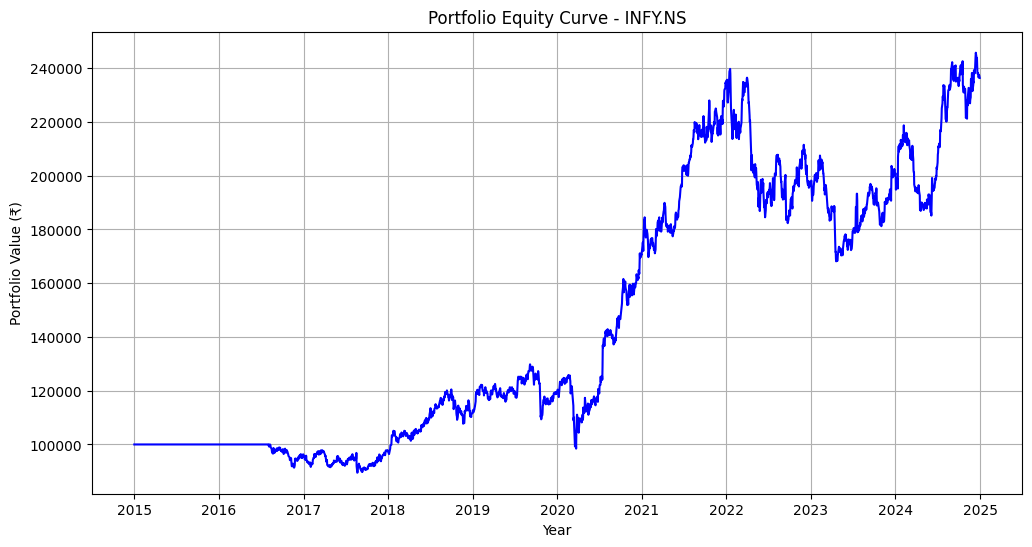

In [6]:
import matplotlib.pyplot as plt
class Backtester:
    def __init__ (self, initial_capital = 100000, position_size = 100):
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.trades_log = []

    def run (self, df):
        df = df.copy ()
        df ['Holdings'] = 0.0
        df ['Cash'] = float (self.initial_capital)
        df ['Portfolio'] = float (self.initial_capital)
        in_position = False
        for i in range (1, len (df)):
            date = df.index [i]
            price = df.at [date, 'Close']
            signal = df.at [date, 'Signal']
            if signal == 1 and not in_position:
                cost = self.position_size * price
                if df.at [date, 'Cash'] >= cost:
                    df.at [date, 'Cash'] -= cost
                    df.at [date, 'Holdings'] = self.position_size * price
                    self.trades_log.append ({'Date': date, 'Action': 'BUY', 'Price': price})
                    in_position = True
            elif signal == -1 and in_position:
                proceeds = self.position_size * price
                df.at [date, 'Cash'] += proceeds
                df.at [date, 'Holdings'] = 0.0
                self.trades_log.append ({'Date': date, 'Action': 'SELL', 'Price': price})
                in_position = False
            else:
                if in_position:
                    df.at [date, 'Holdings'] = self.position_size * price
                else:
                    df.at [date, 'Holdings'] = 0.0
            df.at [date, 'Portfolio'] = df.at [date, 'Cash'] + df.at [date, 'Holdings']
            if i + 1 < len (df):
                next_date = df.index [i + 1]
                df.at [next_date, 'Cash'] = df.at [date, 'Cash']
                df.at [next_date, 'Holdings'] = df.at [date, 'Holdings']
        return df

    def get_trades_log (self):
        return pd.DataFrame (self.trades_log)

class BacktestReport:
    def __init__ (self, df, trades_df, ticker, strategy_name, initial_capital = 100000):
        self.df = df
        self.trades_df = trades_df
        self.ticker = ticker
        self.strategy_name = strategy_name
        self.initial_capital = initial_capital

    def print_report (self):
        returns = self.df ['Portfolio'].pct_change ().dropna ()
        final_value = self.df ['Portfolio'].iloc [-1]
        duration_years = len (self.df) / 252
        cagr = ((final_value / self.initial_capital) ** (1 / duration_years)) - 1
        sharpe = np.mean (returns) / np.std(returns) * np.sqrt(252) if np.std (returns) != 0 else 0
        drawdown = (self.df ['Portfolio'] / self.df ['Portfolio'].cummax ()) - 1
        max_drawdown = drawdown.min ()
        wins = 0
        losses = 0
        for i in range (1, len (self.trades_df), 2):
            if self.trades_df.iloc [i]['Action'] == 'SELL':
                buy_price = self.trades_df.iloc [i - 1]['Price']
                sell_price = self.trades_df.iloc [i]['Price']
                if sell_price > buy_price:
                    wins += 1
                else:
                    losses += 1
        total_trades = wins + losses
        win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
        print ("📈 Strategy Report")
        print ("-" * 19)
        print (f"Stock: {self.ticker}")
        print (f"Strategy: {self.strategy_name}")
        print (f"Total Trades: {total_trades}")
        print (f"Win Rate: {win_rate:.1f} %")
        print (f"Final Portfolio Value: ₹ {final_value:,.2f}")
        print (f"CAGR: {cagr*100:.2f} %")
        print (f"Sharpe Ratio: {sharpe:.2f}")
        print (f"Max Drawdown: {max_drawdown * 100:.2f} %")

    def plot_equity_curve (self):
        plt.figure (figsize = (12,6))
        plt.plot (self.df.index, self.df['Portfolio'], color = 'blue')
        plt.title (f'Portfolio Equity Curve - {self.ticker}')
        plt.ylabel ('Portfolio Value (₹)')
        plt.xlabel ('Year')
        plt.grid (True)
        plt.show ()

df_signals = strategy.generate_signals (df)
backtester = Backtester (initial_capital = 100000, position_size = 100)
df_backtested = backtester.run (df_signals)
trades_log = backtester.get_trades_log ()
report = BacktestReport (df_backtested, trades_log, ticker=ticker, strategy_name  = "Your_Strategy")
report.print_report ()
report.plot_equity_curve ()

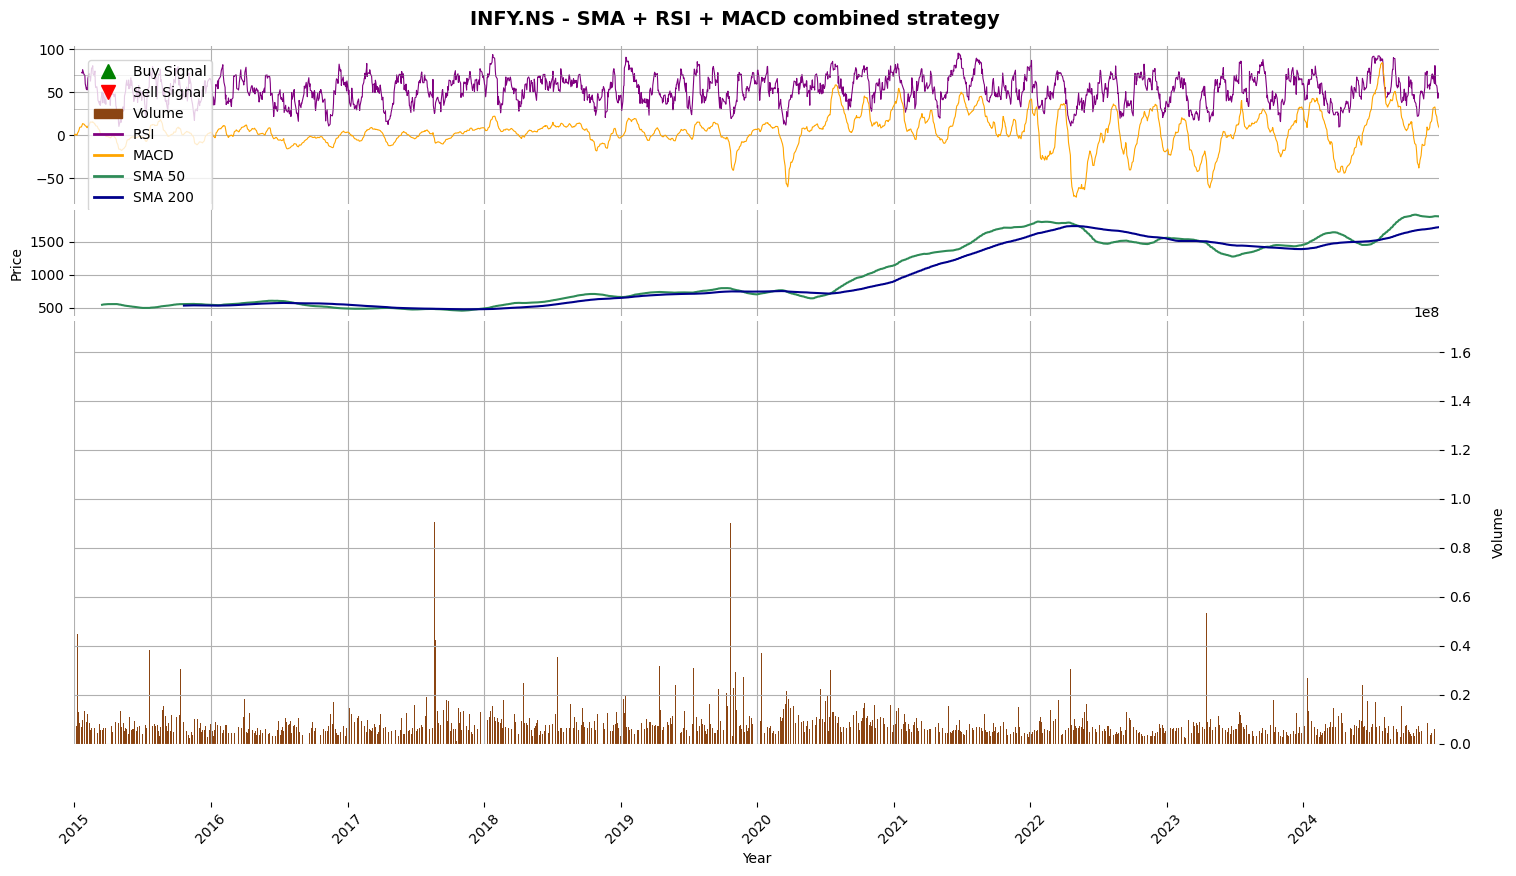

In [7]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_price_volume_rsi_macd (df, ticker, strategy_name):
    fig = plt.figure (figsize = (15, 9))
    fig.patch.set_facecolor ('white')
    plt.suptitle (f'{ticker} - {strategy_name}', fontsize = 14, fontweight = 'bold', y = 0.94)
    gs = plt.GridSpec (4, 1, height_ratios = [1.5, 1, 4, 0.5], hspace = 0.03)
    ax_osc = plt.subplot (gs [0])
    ax_osc.plot (df.index, df ['RSI'], label = 'RSI', color = '#800080', linewidth = 0.8)
    ax_osc.plot (df.index, df ['MACD'], label = 'MACD', color = '#FFA500', linewidth = 0.8)
    ax_osc.axhline (30, color = 'grey', linewidth = 0.7, alpha = 0.5)
    ax_osc.axhline (70, color = 'grey', linewidth = 0.7, alpha = 0.5)
    ax_osc.set_ylabel ('')
    ax_osc.tick_params (axis = 'y', labelcolor = 'black')
    ax_osc.grid (True)
    ax_osc.tick_params (axis = 'x', bottom = False, labelbottom = False)
    ax_price = plt.subplot (gs [1], sharex = ax_osc)
    ax_price.plot (df.index, df ['SMA_50'], label = 'SMA 50', color = '#2E8B57', linewidth = 1.5)
    ax_price.plot (df.index, df ['SMA_200'], label = 'SMA 200', color = '#00008B', linewidth = 1.5)
    ax_price.scatter (df.index [df ['Buy'] == 1], df ['SMA_50'][df ['Buy'] == 1], marker = '^', color = 'green', label = 'Buy Signal', s = 80)
    ax_price.scatter (df.index [df ['Sell'] == 1], df ['SMA_50'][df ['Sell'] == 1], marker = 'v', color = 'red', label = 'Sell Signal', s = 80)
    ax_price.set_ylabel ('Price')
    ax_price.grid (True)
    ax_price.tick_params (axis = 'x', which = 'both', bottom = False, labelbottom = False)

    ax_volume = plt.subplot (gs [2], sharex = ax_osc)
    ax_volume.bar (df.index, df ['Volume'], color = '#8B4513')
    ax_volume.set_ylabel ('Volume', labelpad = 15)
    ax_volume.yaxis.set_label_position ("right")
    ax_volume.yaxis.tick_right ()
    ax_volume.grid (True)
    ax_volume.tick_params (axis = 'x', which = 'both', bottom = False, labelbottom = False)

    ax_x = plt.subplot (gs [3], sharex = ax_osc)
    ax_x.set_xlabel ('Year')
    ax_x.tick_params (axis = 'x', rotation = 45, labelsize = 10)
    ax_x.yaxis.set_visible (False)
    for side in ['top', 'right', 'left', 'bottom']:
        ax_x.spines [side].set_visible (False)
    ax_x.set_xlim (df.index.min (), df.index.max ())
    for ax in [ax_osc, ax_price, ax_volume, ax_x]:
        ax.set_facecolor ('white')
        for spine in ax.spines.values ():
            spine.set_visible (False)

    buy_patch = mlines.Line2D ([], [], color = 'green', marker = '^', linestyle = 'None', markersize = 10, label = 'Buy Signal')
    sell_patch = mlines.Line2D ([], [], color = 'red', marker = 'v', linestyle = 'None', markersize = 10, label = 'Sell Signal')
    volume_patch = mpatches.Patch (color = '#8B4513', label = 'Volume')
    rsi_line = mlines.Line2D ([], [], color = '#800080', linewidth = 2, label = 'RSI')
    macd_line = mlines.Line2D ([], [], color = '#FFA500', linewidth = 2, label = 'MACD')
    sma50_line = mlines.Line2D ([], [], color = '#2E8B57', linewidth = 2, label = 'SMA 50')
    sma200_line = mlines.Line2D ([], [], color = '#00008B', linewidth = 2, label = 'SMA 200')
    handles = [buy_patch, sell_patch, volume_patch, rsi_line, macd_line, sma50_line, sma200_line]
    ax_osc.legend (handles = handles, loc = 'upper left', fontsize = 10, borderaxespad = 1)
    plt.subplots_adjust (top = 0.90, bottom = 0.06, left = 0.06, right = 0.97, hspace = 0.03)
    plt.show ()
plot_price_volume_rsi_macd (df_backtested, ticker, strategy_name)

In [8]:
import time
def poll_live_price (ticker, interval = 10, max_iterations = 10):
    print (f"\n Polling {ticker} every {interval} seconds \n")
    for _ in range (max_iterations):
        data = yf.download (ticker, period = "1d", interval = "1m", progress = False, auto_adjust = False)
        if not data.empty:
            last = data.iloc [-1]
            try:
                open_price = float (last ['Open'].iloc [0]) if isinstance (last ['Open'], pd.Series) else float (last ['Open'])
                close_price = float (last ['Close'].iloc [0]) if isinstance (last ['Close'], pd.Series) else float (last ['Close'])
                timestamp = last.name.to_pydatetime ().strftime ('%H:%M')
                print (f"{timestamp} | Open: {open_price:.2f}, Close: {close_price:.2f}")
            except Exception as e:
                print (f"Skipping due to error: {e}")
        else:
            print ("No data received.")
        time.sleep (interval)
poll_live_price (ticker = ticker, interval = 10, max_iterations = 10)


 Polling INFY.NS every 10 seconds 

07:49 | Open: 1625.00, Close: 1625.00
07:50 | Open: 1625.00, Close: 1625.00
07:50 | Open: 1624.80, Close: 1624.80
07:50 | Open: 1624.80, Close: 1624.80
07:50 | Open: 1624.60, Close: 1624.60
07:50 | Open: 1624.50, Close: 1624.50
07:50 | Open: 1624.80, Close: 1624.80
07:51 | Open: 1624.50, Close: 1624.50
07:51 | Open: 1624.80, Close: 1624.80
07:51 | Open: 1624.90, Close: 1624.90
